# 4.3 SGD를 사용한 MF 기본 알고리즘

In [2]:
import os
import numpy as np
import pandas as pd

base_src =  './Data'
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(u_data_src,
                        sep='\t',
                        names=r_cols,
                        encoding='latin-1')

# timestamp 제거
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

In [6]:
class MF():
    def __init__(self, ratings, hyper_params):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = hyper_params['K']
        self.alpha = hyper_params['alpha']
        self.beta = hyper_params['beta']
        self.iterations = hyper_params['iterations']
        self.verbose = hyper_params['verbose']

    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []

        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)

        return np.sqrt(np.mean(self.errors**2))

    def train(self):
        self.P = np.random.normal(scale=1./self.K,                  # scale = 표준편차를 이야기함
                                    size=(self.num_users, self.K))  # size 실제 유저수와 잠재요인의 갯수 = 크기 값
        self.Q = np.random.normal(scale=1./self.K,
                                    size = (self.num_items, self.K))

        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]

        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse)) # 몇번 째의 RMSE인지?
            if self.verbose:
                if (i+1) % 10 == 0:
                    print('Iteration : %d ; train RMSE = %.4f'%(i + 1, rmse))
        return training_process

    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] +self.b_d[j] + self.P[i, :].dot(self.Q[j,].T)
        return prediction
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r-prediction)

            self.b_u[i] += self.alpha * (e - (self.beta * self.b_u[i]))
            self.b_d[j] += self.alpha * (e - (self.beta * self.b_d[j]))

            self.P[i,:] += self.alpha * ((e * self.Q[j,:] - (self.beta * self.P[i, :])))
            self.Q[j,:] += self.alpha * ((e * self.Q[i,:] - (self.beta * self.Q[j, :])))

R_temp = ratings.pivot(index='user_id',\
                        columns='movie_id',
                        values='rating').fillna(0)

hyper_params = {
    'K' : 30,
    'alpha' : 0.001,
    'beta' : 0.02,
    'iterations' :100,
    'verbose' : True
}

mf = MF(R_temp, hyper_params)

train_process = mf.train()

Iteration : 10 ; train RMSE = 0.9588
Iteration : 20 ; train RMSE = 0.9380
Iteration : 30 ; train RMSE = 0.9291
Iteration : 40 ; train RMSE = 0.9241
Iteration : 50 ; train RMSE = 0.9208
Iteration : 60 ; train RMSE = 0.9185
Iteration : 70 ; train RMSE = 0.9166
Iteration : 80 ; train RMSE = 0.9150
Iteration : 90 ; train RMSE = 0.9135
Iteration : 100 ; train RMSE = 0.9120


# 4.4 train/test 분리 MF 알고리즘

In [18]:
import os
import numpy as np
import pandas as pd

base_src =  './Data'
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(u_data_src,
                        sep='\t',
                        names=r_cols,
                        encoding='latin-1')

# timestamp 제거
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

# train / test set 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75

# (사용자 - 영화 - 평점)
ratings = shuffle(ratings, random_state=2021)   # 모든 사람이 똑같은 raitings가 나오게 됨. 
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]           # 어디까지 
ratings_test = ratings.iloc[cutoff:]            # 어디 이후로 데이터를 뽑으면 될것 인지?

class NEW_MF():
    def __init__(self, ratings, hyper_params):
        self.R = np.array(ratings)
        # 사용자 수 (num_users)와 아이템 수 (num_items)를 받아온다.
        self.num_users, self.num_items = np.shape(self.R)
        # 아래는 MF weight 조절을 위한 하이퍼 파라미더다.
        # K : 잠재요인(latent factor)의 수
        self.K = hyper_params['K']
        # alpha : 학습률
        self.alpha = hyper_params['alpha']
        # beta : 정규화 개수
        self.beta = hyper_params['beta']
        # iterations : SGD의 계산을 할 때 반복 횟수
        self.iterations = hyper_params['iterations']
        # verbose : SGD의 학습 과정을 중간중간에 출력할 것인지에 대한 여부
        self.verbose = hyper_params['verbose']

        # 지난 시간과 조금 다른 부분
        # movie_lens 데이터는 굉장히 잘 정리된 데이터 이지만, 현업의 데이터는 연속값이 아닐 수 있음. 
        # self.R을 numpy로 변환 시킬 경우 중간에 비어있는 실제 id 랑 self.R의 값과 매칭이 안됨.
        ### Item id에 관한 ###
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)    # 어떤 id 값이 들어오더라도 id 값과 numpy array와 매핑 시켜줌.
        self.index_item_id = dict(index_item_id)

        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)


    def rmse(self):
        # self.R에서 평점이 있는 (0이 아닌) 요소의 인덱스를 가져온다.
        xs, ys = self.R.nonzero()
        # prediction과 error를 담을 리스트 변수 초기화
        self.predictions = []
        self.errors = []
        # 평점이 있는 요소(사용자 x, 아이템 y) 각각에 대해서 아래의 코드를 실행한다.
        for x, y in zip(xs, ys):
            # 사용자 x, 아이템 y에 대해서 평점 예측치를 get_prediction()함수를 사용해서 계산한다.
            prediction = self.get_prediction(x, y)
            # 예측값을 예측값 리스트에 추가한다.
            self.predictions.append(prediction)
            # 실제값(R)과 예측값의 차이(errors) 계산해서 오차값 리스트에 추가한다.
            self.errors.append(self.R[x, y] - prediction)
        # 예측값 리스트와 오차값 리스트를 numpy array형태로 변환한다.
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        # error를 활용해서 RMSE를 도출
        return np.sqrt(np.mean(self.errors**2))

    def sgd(self):
        for i, j, r in self.samples:
            # 사용자 i : 아이템 j에 대한 평점 예측치 계산
            prediction = self.get_prediction(i, j)
            # 실제 평점과 비교한 오차 계산
            e = (r - prediction)
            # 사용자 평가 경향 계산 및 업데이트
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            # 아이템 평가 경향 계산 및 업데이트
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])
            # P 행렬 계산 및 업데이트
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            # Q 행렬 계산 및 업데이트
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])
    def get_prediction(self, i, j):
        # 사용자 i, 아이템 j에 대한 평점 예측치를 앞에서 배웠던 식을 이용해서 구한다.
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Test set 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # test set으로 지정한 것들은 모두 0으로
        self.test_set = test_set
        return test_set                   


    # Test set RMSE 계산
    def test_rmse(self):
        error = 0   # 0으로 초기화
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)         # pow : e => e^2 차승
        return np.sqrt(error/len(self.test_set))

    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K,
                                    size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, 
                                    size=(self.num_items, self.K))

        # 유저 경향
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()]) # 온전히 걸린것들만 계산하게 함. 

        # List of training samples
        rows, columns = self.R.nonzero()            # non zero인 것만 인덱스를 가져옴.
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id],
                                    self.item_id_index[item_id])    # 예측치를 계산해줌.
    
    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T) # 전체를 계산해줌.

R_temp = ratings.pivot(index='user_id',
                    columns = 'movie_id',
                    values = 'rating').fillna(0)

hyper_params = {
    'K' : 30,
    'alpha' : 0.001,
    'beta' : 0.02,
    'iterations' : 100,
    'verbose' : True
}

mf = NEW_MF(R_temp, hyper_params)

test_set = mf.set_test(ratings_test)
results = mf.test()


Iteration: 10 ; Train RMSE = 0.9666 ; Test RMSE = 0.9807
Iteration: 20 ; Train RMSE = 0.9412 ; Test RMSE = 0.9623
Iteration: 30 ; Train RMSE = 0.9297 ; Test RMSE = 0.9552
Iteration: 40 ; Train RMSE = 0.9228 ; Test RMSE = 0.9515
Iteration: 50 ; Train RMSE = 0.9179 ; Test RMSE = 0.9493
Iteration: 60 ; Train RMSE = 0.9139 ; Test RMSE = 0.9478
Iteration: 70 ; Train RMSE = 0.9101 ; Test RMSE = 0.9466
Iteration: 80 ; Train RMSE = 0.9059 ; Test RMSE = 0.9455
Iteration: 90 ; Train RMSE = 0.9008 ; Test RMSE = 0.9442
Iteration: 100 ; Train RMSE = 0.8941 ; Test RMSE = 0.9425


In [20]:
print(mf.full_prediction())

[[3.91454543 3.39333233 2.98759373 ... 3.38110623 3.46510384 3.41074121]
 [3.80528174 3.24899288 2.90001427 ... 3.26739582 3.36065561 3.33977482]
 [3.40858422 2.91780662 2.49550962 ... 2.88229575 2.9774935  2.94997816]
 ...
 [4.14704511 3.60480179 3.24708529 ... 3.58197039 3.70818832 3.69413186]
 [4.32293351 3.78026638 3.40714565 ... 3.75817252 3.89115358 3.86689988]
 [3.83928592 3.36202847 2.94700558 ... 3.29387556 3.42047262 3.39708125]]


In [21]:
print(mf.get_one_prediction(1, 2))

3.3933323287310477


# 4.5 MF의 최적 파라미터 찾기

In [24]:
# 최적의 K 찾기
results = []
index = []

R_temp = ratings.pivot(index='user_id',
                        columns='movie_id',
                        values='rating').fillna(0)
for K in range(50, 261, 10):
    print(f'K : {K}')
    hyper_params = {
        'K' : K,
        'alpha' : 0.001,
        'beta' : 0.02,
        'iterations' : 100,
        'verbose' : True
    }
    mf = NEW_MF(R_temp,
                hyper_params)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(K)
    results.append(result)

K : 50
Iteration: 10 ; Train RMSE = 0.9669 ; Test RMSE = 0.9807
Iteration: 20 ; Train RMSE = 0.9417 ; Test RMSE = 0.9622
Iteration: 30 ; Train RMSE = 0.9305 ; Test RMSE = 0.9552
Iteration: 40 ; Train RMSE = 0.9239 ; Test RMSE = 0.9515
Iteration: 50 ; Train RMSE = 0.9195 ; Test RMSE = 0.9493
Iteration: 60 ; Train RMSE = 0.9160 ; Test RMSE = 0.9479
Iteration: 70 ; Train RMSE = 0.9129 ; Test RMSE = 0.9467
Iteration: 80 ; Train RMSE = 0.9097 ; Test RMSE = 0.9458
Iteration: 90 ; Train RMSE = 0.9060 ; Test RMSE = 0.9447
Iteration: 100 ; Train RMSE = 0.9012 ; Test RMSE = 0.9432
K : 60
Iteration: 10 ; Train RMSE = 0.9669 ; Test RMSE = 0.9807
Iteration: 20 ; Train RMSE = 0.9418 ; Test RMSE = 0.9623
Iteration: 30 ; Train RMSE = 0.9307 ; Test RMSE = 0.9552
Iteration: 40 ; Train RMSE = 0.9242 ; Test RMSE = 0.9515
Iteration: 50 ; Train RMSE = 0.9198 ; Test RMSE = 0.9494
Iteration: 60 ; Train RMSE = 0.9165 ; Test RMSE = 0.9479
Iteration: 70 ; Train RMSE = 0.9137 ; Test RMSE = 0.9469
Iteration: 80 ; 

In [26]:
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])

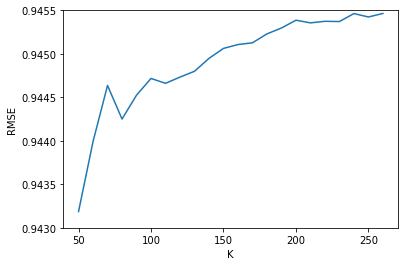

In [43]:
# 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.943, 0.9455)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()
